# Import

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
torch.cuda.empty_cache()
import numpy as np

import pickle
import scipy
import os
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# Modèle

In [52]:
# Définition des classes du modèle (comme dans votre code)
class Generator(nn.Module):
    def __init__(self, seq_len=64, patch_size=24, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate

        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
            depth=self.depth,
            emb_size=self.embed_dim,
            drop_p=self.attn_drop_rate,
            forward_drop_p=self.forward_drop_rate
        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output


class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=1):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out


class PatchEmbedding_Linear(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, emb_size=100, seq_length=1024):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=1, s2=patch_size),
            nn.Linear(patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=1,
                 patch_size=24,
                 emb_size=50,
                 seq_length=24,
                 depth=1,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Config

In [53]:
# Configuration du dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Initialisation

In [54]:
# Paramètres d'entraînement
num_epochs = 10000
batch_size = 16
num_batches = 249 // batch_size
seq_len = 1900
patch_size = 100 # Doit diviser seq_len
latent_dim = 1000
nb_channels = 1
noise = 1
reduc_noise_gap = 500

In [55]:
# Instanciation du générateur et du discriminateur
generator = Generator(seq_len=seq_len, 
                      patch_size=patch_size,
                      channels=nb_channels,
                      latent_dim=latent_dim,
                      ).to(device)
discriminator = Discriminator(in_channels=nb_channels,
                              patch_size=patch_size,
                              emb_size=100,
                              seq_length=seq_len).to(device)

In [56]:
# Variables pour stocker les pertes au fil des époques
losses_D = []
losses_G = []

In [218]:
# Définition de la fonction de perte et des optimiseurs
criterion = nn.BCEWithLogitsLoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Génération Data

In [58]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


# Fonction pour normaliser les signaux
# Problèmes avec cette normalisation : Elle est local et non global sur l'ensemble des signaux

def normalize_data(list_data):

    normalize_data_list = []

    for data in list_data:
        norm = np.linalg.norm(data)
        data_normalized = data / norm
        normalize_data_list.append(data_normalized)
    
    return normalize_data_list


def generate_data(dossier, seq_len=1900, nb_channel=5, noise=10):

    data = []
    
    # On récupère toute la data du dossier
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)

            list_data_from_file = [data_v]


            data.append(list_data_from_file)
    
    nb_files = len(data)
    data = np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

    #####################
    ### Normalisation ###
    #####################

    min_values = []
    max_values = []

    for i in range(nb_channel):
        # Extraire les signaux du canal i
        signaux = data[:, i, 0, :]

        # Calculer min et max
        max_signal = np.max(signaux)
        min_signal = np.min(signaux)

        # Ajouter min et max à leurs listes respectives
        min_values.append(min_signal)
        max_values.append(max_signal)

        # Normaliser les signaux du canal i
        data[:, i, 0, :] = (signaux - min_signal) / (max_signal - min_signal)

    #####################
    #### Ajout Bruit ####
    #####################

    data += np.random.normal(0, noise, data.shape)

    return data, (min_values, max_values)

def affichage_data(signal, seq_len=1900, nb_channels=5):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(12, 5), sharex=True)

    # Si nb_channels est 1, on convertit axs en liste pour unifier la manipulation
    if nb_channels == 1:
        axs = [axs]  # Convertir en liste pour accéder par index

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[np.random.randint(0, signal.shape[0])][i].reshape(seq_len), label=f'Signal réel {i+1}')
        axs[i].grid()
    
    plt.suptitle("Signal")
    plt.show()


In [59]:
folder_path = "echantillon"

data_echantillon, info_normalisation = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

In [60]:
data_echantillon.shape

(5000, 1, 1, 1900)

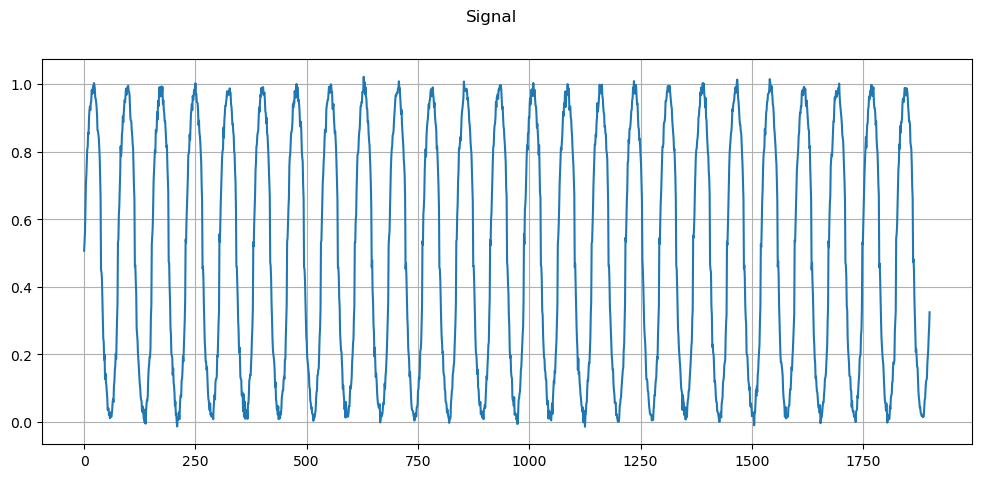

In [217]:
affichage_data(data_echantillon, seq_len, nb_channels=nb_channels)

# Boucle d'entraînement

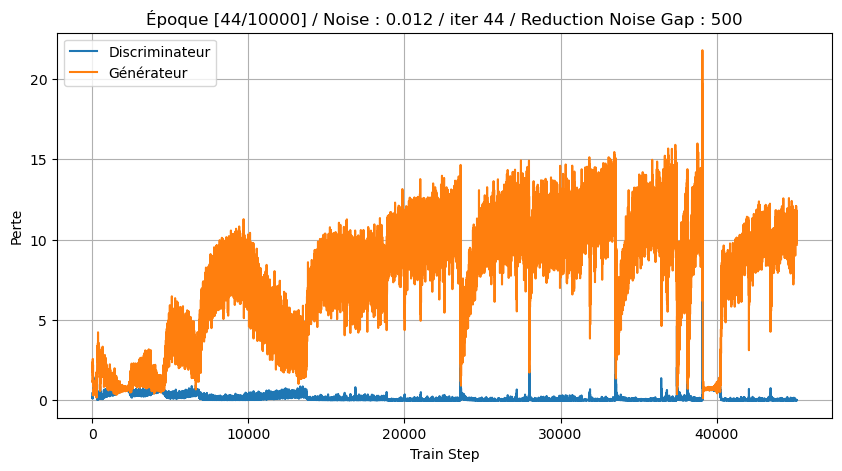

KeyboardInterrupt: 

In [240]:
iter = 0
for epoch in range(num_epochs):

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        # Récupération des données réelles
        real_inputs = data_echantillon[start_idx:end_idx]
        real_inputs = torch.tensor(real_inputs, dtype=torch.float32).to(device)

        # Génération des données factices
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_inputs = generator(z)

        # Entraînement du discriminateur
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        output_real = discriminator(real_inputs)
        loss_real = criterion(output_real, real_labels)

        output_fake = discriminator(fake_inputs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Entraînement du générateur
        optimizer_G.zero_grad()
        fake_labels = torch.ones(batch_size, 1).to(device)  # Le générateur veut que le discriminateur pense que c'est réel
        output = discriminator(fake_inputs)
        loss_G = criterion(output, fake_labels)
        loss_G.backward()
        optimizer_G.step()

        # Stocker les pertes pour affichage
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())

    iter += 1

    if (iter + 1) % reduc_noise_gap == 0:
        noise /= 1.5
        iter = 0
        reduc_noise_gap = int(reduc_noise_gap*1.2)
        data_echantillon, _ = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

    # Affichage des pertes toutes les 10 époques
    if (epoch + 1) % 2 == 0:
        clear_output(wait=True)  # Efface le contenu précédent de la cellule
        
        # Affichage des pertes
        plt.figure(figsize=(10,5))
        plt.plot(losses_D, label="Discriminateur")
        plt.plot(losses_G, label="Générateur")
        plt.xlabel("Train Step")
        plt.ylabel("Perte")
        plt.title(f"Époque [{epoch + 1}/{num_epochs}] / Noise : {noise:.3f} / iter {iter} / Reduction Noise Gap : {reduc_noise_gap}")
        plt.legend()
        plt.grid()
        plt.show()


In [ ]:
reduc_noise_gap = 5000

In [171]:
noise /= 2
print(noise)

data_echantillon, _ = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

0.012345679012345678


# Test affichage

In [19]:
data_echantillon, info_normalisation = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

In [20]:
def denormalisation_signaux(signaux, info_normalisation):

    min = info_normalisation[0]
    max = info_normalisation[1]

    for j in range(signaux.shape[0]):
        for i in range(nb_channels):
            signaux[j, i, 0, :] = signaux[j, i, 0] * (max[i] - min[i]) + min[i]

    return signaux

(5000, 1, 1, 1900)
(1, 1, 1, 1900)


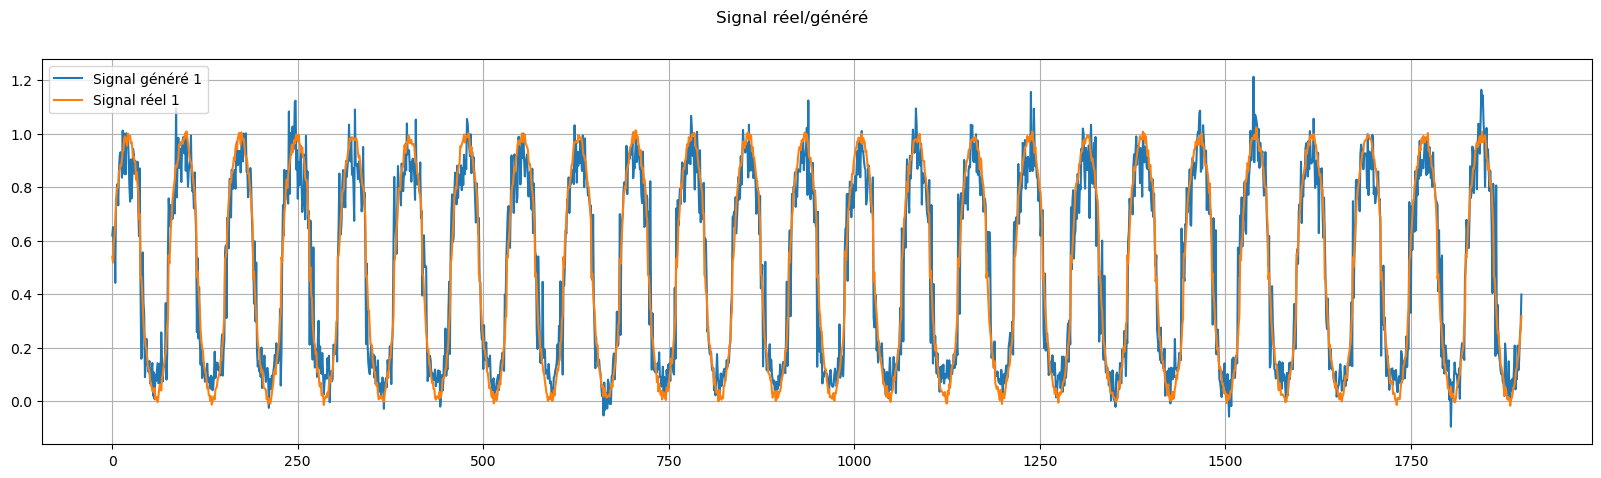

In [242]:
real_signal = data_echantillon.copy()
print(real_signal.shape)

# Génération d'un signal factice
z = torch.randn(1, latent_dim).to(device)
generated_signal = generator(z).detach().cpu().numpy()
print(generated_signal.shape)

# generated_signal = denormalisation_signaux(generated_signal, info_normalisation)
# real_signal = denormalisation_signaux(real_signal, info_normalisation)

# Diviser le plot en 5 parties
fig, axs = plt.subplots(nb_channels, 1, figsize=(20, 5), sharex=True)

# Si nb_channels est 1, on convertit axs en liste pour unifier la manipulation
if nb_channels == 1:
    axs = [axs]  # Convertir en liste pour accéder par index

# Affichage du signal réel
for i in range(nb_channels):

    axs[i].plot(generated_signal[0][i].reshape(seq_len), label=f'Signal généré {i+1}')
    axs[i].plot(real_signal[np.random.randint(0, real_signal.shape[0])][i].reshape(seq_len), label=f'Signal réel {i+1}')
    # axs[i].set_ylim(-1, 1)  # Limites de l'axe y entre -1 et 1
    axs[i].legend()
    axs[i].grid()

plt.suptitle("Signal réel/généré")
plt.show()


# Sauvegarde du modèle

In [238]:
save_dir = "model_saved/1900_voltage_0.010_bien_12_11_2024"

os.makedirs(save_dir, exist_ok=True)

In [239]:
# Sauvegarde du générateur
torch.save(generator.state_dict(), os.path.join(save_dir, 'generator.pth'))

# Sauvegarde du discriminateur
torch.save(discriminator.state_dict(), os.path.join(save_dir, 'discriminator.pth'))

# Sauvegarde des infos pour dénormaliser les signaux générés
with open(os.path.join(save_dir, 'info_normalisation.pkl'), 'wb') as f:
    pickle.dump(info_normalisation, f)

info_modele = [batch_size, seq_len, patch_size, latent_dim, nb_channels]

# Sauvegarde des infos pour initialiser le modèle
with open(os.path.join(save_dir, 'info_model.pkl'), 'wb') as f:
    pickle.dump(info_modele, f)

print("Les modèles et les infos ont été sauvegardés avec succès.")

Les modèles et les infos ont été sauvegardés avec succès.
